# modelo 04

efficinet net + unfroze backbone 20 layers + weights for outputs imbalance + extra features

In [30]:
import pandas as pd

In [31]:
df_train = pd.read_pickle('Model_Train.pkl')
df_val = pd.read_pickle('Model_Val.pkl')

In [32]:
set(df_train["img_placement"]) | set(df_val["img_placement"])

{'S-unknown', 'openspace', 'r_openspace', 'roof'}

In [33]:
set(df_train["img_origin"]) | set(df_val["img_origin"])

{'D', 'S'}

In [34]:
def hot_encod_img_placement(df):
    extra_features_all = []
    for i, row in df.iterrows():
        extra_features = []
        if row["img_placement"] == "roof":
            extra_features += [1, 0, 0, 0]
        elif row["img_placement"] == "r_openspace":
            extra_features += [0, 1, 0, 0]
        elif row["img_placement"] == "openspace":
            extra_features += [0, 0, 1, 0]
        elif row["img_placement"] == "S-unknown":
            extra_features += [0, 0, 0, 1]
        else:
            extra_features += [0, 0, 0, 0]
        if row["img_origin"] == "D":
            extra_features += [1, 0]
        elif row["img_origin"] == "S":
            extra_features += [0, 1]
        else:
            extra_features += [0, 0] 
        extra_features_all.append(extra_features)
    
    df["more_features"] = extra_features_all

    df.drop(columns=["img_origin"], inplace=True)
    df.drop(columns=["img_placement"], inplace=True)

hot_encod_img_placement(df_train)
hot_encod_img_placement(df_val)

In [35]:
df_train.sample(3)

,img_id,nr_boil,polygons_boil,nr_pan,polygons_pan,more_features
1260,IDlYV34uyVIrkrMB,[],[],"[4, 2]","[[(358.0121212121212, 116.35187057633973), (38...","[1, 0, 0, 0, 1, 0]"
1792,IDdWmF5rFPXdsGfw,[],[],[1],"[[(236.672, 207.36), (258.816, 216.064), (242....","[1, 0, 0, 0, 1, 0]"
1293,ID09pzWgf,[],[],"[29, 29, 29, 29, 29, 29]","[[(178.5546218487395, 200.68341708542712), (20...","[0, 0, 0, 1, 0, 1]"


---

weights

In [36]:
total_boil = 0
total_pan = 0
for i, row in df_train.iterrows():
    total_boil += sum(row["nr_boil"])
    total_pan += sum(row["nr_pan"])

total_boil, total_pan

(591, 11395)

In [37]:
weights_boil = total_boil / (total_boil + total_pan)
weights_pan = total_pan / (total_boil + total_pan)

weights_boil, weights_pan

(0.04930752544635408, 0.9506924745536459)

## efficient net v2

In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetV2B1
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import AdamW
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence

In [39]:
class ImageDataGeneratorCustom(tf.keras.utils.Sequence):
    def __init__(self, df, image_size=(512, 512), batch_size=32, shuffle=True, augment=False):
        self.df = df
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = self.df.index.values
        self.on_epoch_end()

        if self.augment:
            self.transform = A.Compose([
                A.RandomResizedCrop((self.image_size[0], self.image_size[1]), scale=(0.7, 1.0), ratio=(0.75, 1.33)),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.GaussianBlur(blur_limit=(3, 7), p=0.3),
                A.CLAHE(clip_limit=4.0, p=0.5),
                A.HueSaturationValue(p=0.3),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])
        else:
            # If no augmentation, only resize and normalize
            self.transform = A.Compose([
                A.Resize(self.image_size[0], self.image_size[1]),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
            ])

    def __len__(self):
        # Calculate the number of batches per epoch
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle the data at the end of each epoch if shuffle is True
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)
            #np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # Get batch of data
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        images = []
        nr_boil = []
        nr_pan = []
        extra_features = []

        for i, row in batch_df.iterrows():
            # Load image
            image_path = "images/" + row['img_id'] + '.jpg'
            img = load_img(image_path, target_size=self.image_size)
            img = img_to_array(img)  # Convert to numpy array
            img = img / 255.0 # Normalize pixel values
            
            img = self.transform(image=img)["image"]

            if img.shape[0] == 3:  # If it's in channels-first format (3, 512, 512)
                img = np.transpose(img, (1, 2, 0))

            
            images.append(img)
            nr_boil.append(sum(row["nr_boil"]))
            nr_pan.append(sum(row["nr_pan"]))
            extra_features.append(row["more_features"])

        return (np.array(images), np.array(extra_features)), (np.array(nr_boil), np.array(nr_pan))


In [40]:
train_generator = ImageDataGeneratorCustom(df_train, image_size=(512, 512), batch_size=32, shuffle=True, augment=True)
val_generator = ImageDataGeneratorCustom(df_val, image_size=(512, 512), batch_size=32, shuffle=False, augment=False)

In [41]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import EfficientNetV2B1
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import Huber
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

# Define image input
image_input = Input(shape=(512, 512, 3), name="image_input")

# Define extra features input (6 additional features)
extra_input = Input(shape=(6,), name="extra_features")

# Base model (EfficientNetV2-B1 without the top layers)
base_model = EfficientNetV2B1(weights="imagenet", include_top=False, input_tensor=image_input)
for layer in base_model.layers[-5:]:  # Unfreeze last 20 layers
    layer.trainable = True

# Feature extraction from CNN
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions

# Merge image features with extra input
x = Concatenate()([x, extra_input])  # Combine CNN features with extra features

# Dense layers
x = Dense(512)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Separate output layers
output1 = Dense(1, name="output1")(x)  # First regression target
output2 = Dense(1, name="output2")(x)  # Second regression target

# Define and compile the model
model = Model(inputs=[image_input, extra_input], outputs=[output1, output2])

model.compile(
    optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss={"output1": Huber(delta=1.0), "output2": Huber(delta=1.0)},
    loss_weights={"output1": 1.0, "output2": 0.1},
    metrics=[["mae"], ["mae"]])

In [43]:
#model.summary()

In [44]:
from tensorflow.keras import callbacks
from time import time

# Define ModelCheckpoint to save model after each epoch
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=f"ModelBuild/Model04_{int(time())}.keras",
    save_weights_only=False,
    save_best_only=True,
    monitor="val_loss", 
    verbose=1
)

# Early stopping to prevent overfitting
early_stopping_callback = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

#history = model.fit(train_generator,
#          validation_data=val_generator,
#          epochs=20,
#          callbacks=[checkpoint_callback, early_stopping_callback])

#model.save('ModelBuild/model04.keras')

In [45]:
import json

#data = history.history
#with open('ModelBuild/model04_history.json', 'w') as f:
#    json.dump(data, f)

with open('ModelBuild/model04_history.json', 'r') as f:
    data = json.load(f)

In [46]:
data.keys()

dict_keys(['loss', 'output1_loss', 'output1_mae', 'output2_loss', 'output2_mae', 'val_loss', 'val_output1_loss', 'val_output1_mae', 'val_output2_loss', 'val_output2_mae'])

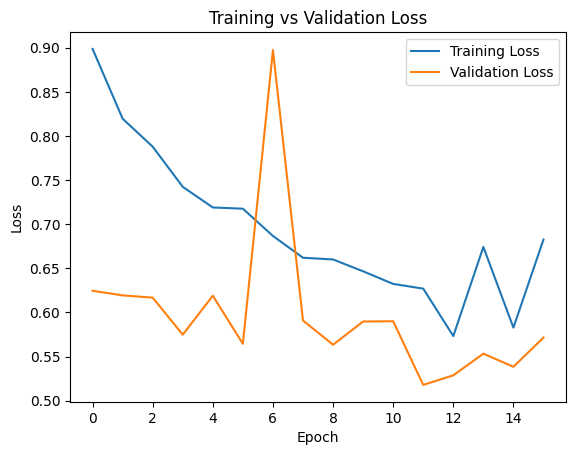

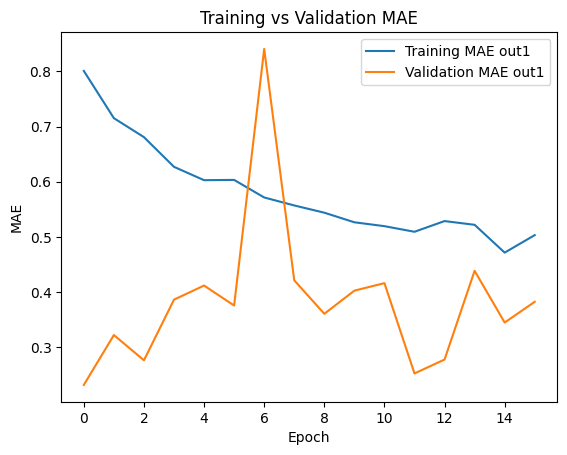

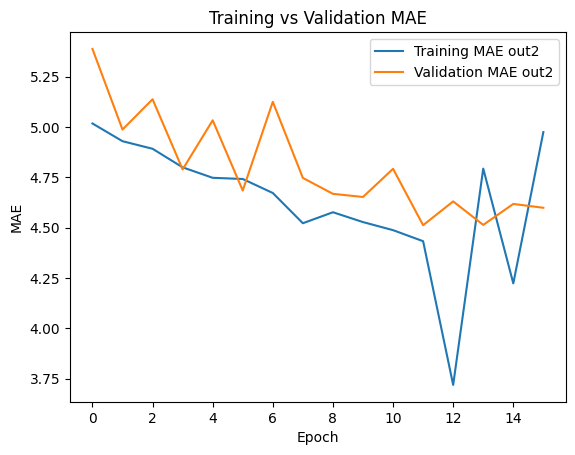

In [47]:
plt.plot(data['loss'], label='Training Loss')
plt.plot(data['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(data['output1_mae'], label='Training MAE out1')
plt.plot(data['val_output1_mae'], label='Validation MAE out1')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

plt.plot(data['output2_mae'], label='Training MAE out2')
plt.plot(data['val_output2_mae'], label='Validation MAE out2')
plt.title('Training vs Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

---
---

---
---

---
---

a grande diferenca entre maes entre outputs leva a querer q tlvz seja boa ideia criar dois modelos distintos, um para cada output permitindo um maior foco em cada um deles

de qq forma, vamos ver o estado atual do modelo, prevendo o teste

In [48]:
model = tf.keras.models.load_model('ModelBuild/model04.keras')

In [49]:
submission = pd.read_csv("zindi_files/SampleSubmission.csv")
submission.head()

,ID,Target
0,ID00qprY_boil,0
1,ID00qprY_pan,0
2,ID01AciUc_boil,0
3,ID01AciUc_pan,0
4,ID0328D_boil,0


In [50]:
test = pd.read_csv("Test.csv")
test.head()

,ID,img_origin,placement
0,ID00qprY,D,roof
1,ID01AciUc,D,roof
2,ID0328D,D,roof
3,ID05WxObCFTs9,D,roof
4,ID06AdCmLMlkO,S,S-unknown


In [51]:
def hot_encod_img_placement(df):
    extra_features_all = []
    for i, row in df.iterrows():
        extra_features = []
        if row["placement"] == "roof":
            extra_features += [1, 0, 0, 0]
        elif row["placement"] == "r_openspace":
            extra_features += [0, 1, 0, 0]
        elif row["placement"] == "openspace":
            extra_features += [0, 0, 1, 0]
        elif row["placement"] == "S-unknown":
            extra_features += [0, 0, 0, 1]
        else:
            extra_features += [0, 0, 0, 0]
        if row["img_origin"] == "D":
            extra_features += [1, 0]
        elif row["img_origin"] == "S":
            extra_features += [0, 1]
        else:
            extra_features += [0, 0] 
        extra_features_all.append(extra_features)
    
    df["more_features"] = extra_features_all

    df.drop(columns=["img_origin"], inplace=True)
    df.drop(columns=["placement"], inplace=True)

hot_encod_img_placement(test)

In [52]:
test.head()

,ID,more_features
0,ID00qprY,"[1, 0, 0, 0, 1, 0]"
1,ID01AciUc,"[1, 0, 0, 0, 1, 0]"
2,ID0328D,"[1, 0, 0, 0, 1, 0]"
3,ID05WxObCFTs9,"[1, 0, 0, 0, 1, 0]"
4,ID06AdCmLMlkO,"[0, 0, 0, 1, 0, 1]"


In [54]:
transform = A.Compose([
    A.Resize(512,512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

for i, row in test.iterrows():
    # Load image
    image_path = "images/" + row['ID'] + '.jpg'
    img = load_img(image_path, target_size=(512,512))
    img = img_to_array(img)  # Convert to numpy array
    img = img / 255.0 # Normalize pixel values

    img = transform(image=img)["image"]

    if img.shape[0] == 3:  # If it's in channels-first format (3, 512, 512)
        img = np.transpose(img, (1, 2, 0))

    extra_features = row["more_features"]
    extra_features = np.array(extra_features).reshape(1, -1)

    prediction = model.predict([np.array([img]), extra_features], verbose=0)


    
    submission.loc[submission['ID'] == f"{row['ID']}_boil", "Target"] = prediction[0][0]
    submission.loc[submission['ID'] == f"{row['ID']}_pan", "Target"] = prediction[1][0]

    if i % 100 == 0:
        print(f"Predicted {i} images of {len(test)}")

    #print(prediction)

submission.head()

/var/folders/sz/96b_h5gn3y33k0c7jsvrstmm0000gn/T/ipykernel_21851/620341202.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.06395195]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  submission.loc[submission['ID'] == f"{row['ID']}_boil", "Target"] = prediction[0][0]


Predicted 0 images of 1107
Predicted 100 images of 1107
Predicted 200 images of 1107
Predicted 300 images of 1107
Predicted 400 images of 1107
Predicted 500 images of 1107
Predicted 600 images of 1107
Predicted 700 images of 1107
Predicted 800 images of 1107
Predicted 900 images of 1107
Predicted 1000 images of 1107
Predicted 1100 images of 1107


,ID,Target
0,ID00qprY_boil,0.063952
1,ID00qprY_pan,0.670790
2,ID01AciUc_boil,-0.029433
3,ID01AciUc_pan,0.290120
4,ID0328D_boil,0.024319


In [55]:
submission.to_csv('ModelBuild/model04_submission.csv', index=False)

**public submission result:** 3.15...